
# Stanford cs224d (NLP) assigment 3: sentiment with recursive network


In [1]:
%cd "C:\Users\h_agu\Desktop\machine_learning\cs224d\assignment3\codebase_release"
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import itertools
import shutil
import tensorflow as tf
import tree as tr
from utils import Vocab

C:\Users\h_agu\Desktop\machine_learning\cs224d\assignment3\codebase_release


In [2]:
RESET_AFTER = 50
class Config(object):
    """Holds model hyperparams and data information.
       Model objects are passed a Config() object at instantiation.
    """
    embed_size = 35
    #embed_size = 70
    label_size = 2
    early_stopping = 2
    anneal_threshold = 0.99
    anneal_by = 1.5
    max_epochs = 35
    #max_epochs = 1
    lr = 0.01
    l2 = 0.04
    zr = 1e-9
    model_name = 'rnn_embed=%d_l2=%f_lr=%f.weights'%(embed_size, l2, lr)

In [5]:
class RNN_Model():

    def load_data(self):
        """Loads train/dev/test data and builds vocabulary."""
        self.train_data, self.dev_data, self.test_data = tr.simplified_data(700, 100, 200)

        # build vocab from training data
        self.vocab = Vocab()
        train_sents = [t.get_words() for t in self.train_data]
        self.vocab.construct(list(itertools.chain.from_iterable(train_sents)))

    def inference(self, tree, predict_only_root=False):
        """For a given tree build the RNN models computation graph up to where it
            may be used for inference.
        Args:
            tree: a Tree object on which to build the computation graph for the RNN
        Returns:
            softmax_linear: Output tensor with the computed logits.
        """
        with tf.name_scope("inference"):
            node_tensors = self.add_model(tree.root)
            if predict_only_root:
                node_tensors = node_tensors[tree.root]
            else:
                node_tensors = [tensor for node, tensor in node_tensors.items() if node.label!=2]
                node_tensors = tf.concat(0, node_tensors)
            return self.add_projections(node_tensors)

    def add_model_vars(self):
        '''
        You model contains the following parameters:
            embedding:  tensor(vocab_size, embed_size)
            W1:         tensor(2* embed_size, embed_size)
            b1:         tensor(1, embed_size)
            U:          tensor(embed_size, output_size)
            bs:         tensor(1, output_size)
        Hint: Add the tensorflow variables to the graph here and *reuse* them while building
                the compution graphs for composition and projection for each tree
        Hint: Use a variable_scope "Composition" for the composition layer, and
              "Projection") for the linear transformations preceding the softmax.
        '''
        with tf.variable_scope('Embedding'):
            self.embedding = tf.get_variable("embedding"
                                             ,[len(self.vocab.word_to_index),self.config.embed_size]
                                             #,initializer=tf.random_normal_initializer(stddev=0.02)
                                            )
            
        
        with tf.variable_scope('Composition'):
            ### YOUR CODE HERE


            #tf.Variable(tf.random_uniform([len(self.vocab.word_to_index),self.config.embed_size],self.config.zr,1.0),name="embedding")
            self.W1 = tf.get_variable("W1"
                                      ,[2*self.config.embed_size,self.config.embed_size]
                                      #,initializer=tf.random_normal_initializer(stddev=0.02)
                                      #,initializer=tf.random_normal_initializer()
                                      #,initializer=tf.random_uniform_initializer(minval=self.config.zr,maxval=0.01)
                                     )
            self.b1 = tf.get_variable("b1"
                                      ,[1,self.config.embed_size]
                                      #,initializer=tf.random_uniform_initializer(minval=self.config.zr,maxval=0.01)
                                     )

        with tf.variable_scope('Projection'):
            ### YOUR CODE HERE
            self.U = tf.get_variable("U"
                                     ,[self.config.embed_size, self.config.label_size]
                                     #,initializer=tf.random_normal_initializer(stddev=0.02)
                                     #,initializer=tf.random_normal_initializer()
                                     #,initializer=tf.random_uniform_initializer(minval=self.config.zr,maxval=0.01)
                                    )
            #tf.Variable(tf.random_uniform([self.config.embed_size, self.config.label_size],self.config.zr,1.0),name="U")
            #self.bs = tf.Variable(tf.constant(0.001,shape=[1,self.config.label_size]),name="bs")
            self.bs = tf.get_variable("bs"
                                      ,[1,self.config.label_size]
                                     # ,initializer=tf.random_uniform_initializer(minval=self.config.zr,maxval=0.01)
                                     )
            #tf.Variable(tf.zeros([1,self.config.label_size]), name="bs")
            #tf.summary.histogram("p_weight_U",self.U)
            #tf.summary.histogram("bias_bs",self.bs)
            ### END YOUR CODE

    def add_model(self, node):
        """Recursively build the model to compute the phrase embeddings in the tree

        Hint: Refer to tree.py and vocab.py before you start. Refer to
              the model's vocab with self.vocab
        Hint: Reuse the "Composition" variable_scope here
        Hint: Store a node's vector representation in node.tensor so it can be
              used by it's parent
        Hint: If node is a leaf node, it's vector representation is just that of the
              word vector (see tf.gather()).
        Args:
            node: a Node object
        Returns:
            node_tensors: Dict: key = Node, value = tensor(1, embed_size)
        """
        
        with tf.variable_scope('Embedding', reuse=True):
            #embedding=tf.get_variable("embedding",[len(self.vocab.word_to_index),self.config.embed_size])
            embedding=tf.get_variable("embedding")
            #tf.summary.histogram("embedding",embedding) # tensorboard 
            
        with tf.variable_scope('Composition', reuse=True):
            ### YOUR CODE HERE
            W1=tf.get_variable("W1")
            b1=tf.get_variable("b1")
           
            #tf.summary.histogram("h_weight_W1",W1) # tensorboar
            #tf.summary.histogram("bias_b1",b1)  # tensorboard
            ### END YOUR CODE


        node_tensors = dict()
        curr_node_tensor = None
        #c=None
        if node.isLeaf:
            ### YOUR CODE HERE
            #curr_node_tensor['key']=node
            #try:
            #    widx=self.vocab.word_to_index[node.word]
            #except KeyError:
            #    widx=0
            with tf.name_scope("node_input"):
                #with tf.device('/cpu:0'):
                    #curr_node_tensor=tf.reshape(tf.nn.embedding_lookup(embedding,self.vocab.encode(node.word),0),[1,self.config.embed_size])
               curr_node_tensor=tf.reshape(embedding[self.vocab.encode(node.word)],[1,self.config.embed_size]) 
            ### END YOUR CODE
        else:
            node_tensors.update(self.add_model(node.left))
            node_tensors.update(self.add_model(node.right))
            with tf.name_scope("nodes_hidden_layer"):
                d=tf.concat(1,[node_tensors[node.left],node_tensors[node.right]])
                #d=tf.reshape(c, [1,2*self.config.embed_size])
                #curr_node_tensor=tf.nn.tanh(tf.matmul(d,W1)+b1)
                curr_node_tensor=tf.nn.relu(tf.matmul(d,W1)+b1)
                #curr_node_tensor=tf.nn.relu
            ### END YOUR CODE
        node_tensors[node] = curr_node_tensor
        return node_tensors

    def add_projections(self, node_tensors):
        """Add projections to the composition vectors to compute the raw sentiment scores

        Hint: Reuse the "Projection" variable_scope here
        Args:
            node_tensors: tensor(?, embed_size)
        Returns:
            output: tensor(?, label_size)
        """
        logits = None
        ### YOUR CODE HERE
        with tf.variable_scope('Projection', reuse=True):
            U=tf.get_variable("U")
            bs=tf.get_variable("bs")
            with tf.name_scope("nodes_scores"):
                logits=tf.matmul(node_tensors,U)+bs
                
            #tf.summary.histogram("p_weight_U",self.U) # tensorboard
            #tf.summary.histogram("bias_bs",self.bs) # tensorboard
        
            
        ### END YOUR CODE
        return logits

    def loss(self, logits, labels):
        """Adds loss ops to the computational graph.

        Hint: Use sparse_softmax_cross_entropy_with_logits
        Hint: Remember to add l2_loss (see tf.nn.l2_loss)
        Args:
            logits: tensor(num_nodes, output_size)
            labels: python list, len = num_nodes
        Returns:
            loss: tensor 0-D
        """
        loss = None
        # YOUR CODE HERE +self.config.lr*tf.nn.l2_loss(self.U)
                                      
        with tf.variable_scope('Projection',reuse=True):
            U=tf.get_variable("U")
                                      
        with tf.variable_scope('Composition',reuse=True):
            W1=tf.get_variable("W1")
                                      
        with tf.name_scope("loss"):
            loss=tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,tf.constant(labels))) 
        #tf.summary.scalar("loss_xent",loss) # tensorboard
            loss=loss+self.config.lr*(tf.nn.l2_loss(U)+tf.nn.l2_loss(W1))
        #tf.summary.scalar("loss_w_reg",loss) # tensorboard
        # END YOUR CODE
        return loss

    def training(self, loss):
        """Sets up the training Ops.

        Creates an optimizer and applies the gradients to all trainable variables.
        The Op returned by this function is what must be passed to the
        `sess.run()` call to cause the model to train. See

        https://www.tensorflow.org/versions/r0.7/api_docs/python/train.html#Optimizer

        for more information.

        Hint: Use tf.train.GradientDescentOptimizer for this model.
                Calling optimizer.minimize() will return a train_op object.

        Args:
            loss: tensor 0-D
        Returns:
            train_op: tensorflow op for training.
        """
        train_op = None
        # YOUR CODE HERE
        with tf.name_scope("GradientDescent"):
            opt=tf.train.GradientDescentOptimizer(self.config.lr)
            train_op=opt.minimize(loss)
        # END YOUR CODE
        return train_op

    def predictions(self, y):
        """Returns predictions from sparse scores

        Args:
            y: tensor(?, label_size)
        Returns:
            predictions: tensor(?,1)
        """
        predictions = None
        # YOUR CODE HERE
        with tf.name_scope("Prediction"):
            #soft=tf.nn.softmax(y)
        #row=tf.shape(y)[0]
            predictions = tf.argmax(y,1)        
        # END YOUR CODE
        return predictions

    def __init__(self, config):
        self.config = config
        self.load_data()

    def predict(self, trees, weights_path, get_loss = False):
        """Make predictions from the provided model."""
        results = []
        losses = []
        for i in range(int(math.ceil(len(trees)/float(RESET_AFTER)))):
            with tf.Graph().as_default(), tf.Session() as sess:
                self.add_model_vars()
                saver = tf.train.Saver()
                saver.restore(sess, weights_path)
                for tree in trees[i*RESET_AFTER: (i+1)*RESET_AFTER]:
                    logits = self.inference(tree, True)
                    predictions = self.predictions(logits)
                    root_prediction = sess.run(predictions)[0]
                    if get_loss:
                        root_label = tree.root.label
                        loss = sess.run(self.loss(logits, [root_label]))
                        losses.append(loss)
                    results.append(root_prediction)
        return results, losses

    def run_epoch(self, new_model = False, verbose=True):
        step = 0
        loss_history = []
        train_pred = []
        embed_history = []
        tf.reset_default_graph()
        #writer = self.writer # tensorboard
        
        while step < len(self.train_data):
            with tf.Graph().as_default(), tf.Session() as sess:    
                self.add_model_vars()
                if new_model:
                    init = tf.global_variables_initializer()
                    sess.run(init)
                else:
                    saver = tf.train.Saver()
                    saver.restore(sess, './weights/%s.temp'%self.config.model_name)
                for _ in range(RESET_AFTER):
                    if step>=len(self.train_data):
                        break
                    tree = self.train_data[step]
                    logits = self.inference(tree)
                    labels = [l for l in tree.labels if l!=2]
                    loss = self.loss(logits, labels)
                    tf.summary.scalar('loss',loss) # tensorboard
                    train_op = self.training(loss)
                    if step%100==0:
#                        summ = tf.summary.merge_all() # for tensorboard
                        with tf.variable_scope('Embedding', reuse=True):
                            emb = tf.get_variable("embedding")
                        #loss, s_out, embedding, _ = sess.run([loss, summ, emb, train_op]) # adding tensorfboard summarry
                        loss, embedding, _ = sess.run([loss, emb, train_op])
                        embed_history.append((np.array(embedding).T).ravel())
#                        writer.add_summary(s_out,step) # adding tensorfboard summarry
                    else:
                        loss, _= sess.run([loss, train_op])
                    
                    loss_history.append(loss)
                    #print("loss_hist",loss_history)
#                    tf.summary.histogram("loss",loss) # tensorboard
                    if verbose:
                        sys.stdout.write('\r{} / {} :    loss = {}'.format(
                            step, len(self.train_data), np.mean(loss_history)))
                        sys.stdout.flush()
#                    if step == 1:
#                        writer.add_graph(sess.graph)
                    step+=1
                saver = tf.train.Saver()
                if not os.path.exists("./weights"):
                    os.makedirs("./weights")
                saver.save(sess, './weights/%s.temp'%self.config.model_name)
                
        #saver.save(sess, './weights/%s'%self.config.model_name + '.%d'%self.epoch)  
        shutil.copyfile('./weights/%s.temp.index'%self.config.model_name, './weights/%s'%self.config.model_name+'.%d.index'%self.epoch)
        shutil.copyfile('./weights/%s.temp.meta'%self.config.model_name, './weights/%s'%self.config.model_name+'.%d.meta'%self.epoch)
        shutil.copyfile('./weights/%s.temp.data-00000-of-00001'%self.config.model_name, './weights/%s'%self.config.model_name+'.%d.data-00000-of-00001'%self.epoch)

        print("\nlr: ", self.config.lr)
        np.savetxt('embed/embed_%d_'%self.start_time+'epoch_%02d.txt'%self.epoch,embed_history,fmt='%f')
                
        train_preds, _ = self.predict(self.train_data, './weights/%s'%self.config.model_name + '.%d'%self.epoch)
        val_preds, val_losses = self.predict(self.dev_data, './weights/%s'%self.config.model_name + '.%d'%self.epoch, get_loss=True)
        train_labels = [t.root.label for t in self.train_data]
        val_labels = [t.root.label for t in self.dev_data]
        train_acc = np.equal(train_preds, train_labels).mean()
        val_acc = np.equal(val_preds, val_labels).mean()
        self.pref_epoch=self.epoch
        
        print()
        print('Training acc (only root node): {}'.format(train_acc))
        print('Valiation acc (only root node): {}'.format(val_acc))
        print(self.make_conf(train_labels, train_preds))
        print(self.make_conf(val_labels, val_preds))
        return train_acc, val_acc, loss_history, np.mean(val_losses)

    def train(self, verbose=True):
        complete_loss_history = []
        train_acc_history = []
        val_acc_history = []
        prev_epoch_loss = float('inf')
        best_val_loss = float('inf')
        best_val_epoch = 0
        stopped = -1
        print("l2",self.config.l2)
        for epoch in range(self.config.max_epochs):
            print('epoch %02d'%epoch)
            self.epoch=epoch
#            self.writer = tf.summary.FileWriter('./tensorboard/log/normal/epoch_%s'%str(epoch))
            #self.writer.add_graph(tf.get_default_graph())
            if epoch==0:
                train_acc, val_acc, loss_history, val_loss = self.run_epoch(new_model=True)
            else:
                train_acc, val_acc, loss_history, val_loss = self.run_epoch()
            complete_loss_history.extend(loss_history)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            #lr annealing
            epoch_loss = np.mean(loss_history)
            if epoch_loss>prev_epoch_loss*self.config.anneal_threshold:
                self.config.lr/=self.config.anneal_by
                print('annealed lr to %f'%self.config.lr)
            prev_epoch_loss = epoch_loss

            #save if model has improved on val
            if val_loss < best_val_loss:
                try:
                    #print('\ncopyfile:',self.start_time," ",self.epoch)
                    shutil.copyfile('./weights/%s.temp.index'%self.config.model_name, './weights/%s.index'%self.config.model_name)
                    #shutil.copyfile('./weights/%s'%self.config.model_name + '.%d.index'%self.pref_epoch, './weights/%s.index'%self.config.model_name)
                    shutil.copyfile('./weights/%s.temp.meta'%self.config.model_name, './weights/%s.meta'%self.config.model_name)
                    #shutil.copyfile('./weights/%s'%self.config.model_name + '.%d.meta'%self.pref_epoch, './weights/%s.meta'%self.config.model_name)
                    shutil.copyfile('./weights/%s.temp.data-00000-of-00001'%self.config.model_name, './weights/%s.data-00000-of-00001'%self.config.model_name)
                    #shutil.copyfile('./weights/%s'%self.config.model_name + '.%d.data-00000-of-00001'%self.pref_epoch, './weights/%s.data-00000-of-00001'%self.config.model_name)
                    print('\ncopyfile:',self.start_time," ",self.epoch)
                finally:
                    best_val_loss = val_loss
                    best_val_epoch = epoch

            # if model has not imprvoved for a while stop
            if epoch - best_val_epoch > self.config.early_stopping:
                stopped = epoch
                #break
        if verbose:
                sys.stdout.write('\r')
                sys.stdout.flush()

        print('\n\nstopped at %d\n'%stopped)
        return {
            'loss_history': complete_loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
            }

    def make_conf(self, labels, predictions):
        confmat = np.zeros([2, 2])
        for l,p in zip(labels, predictions):
            confmat[l, p] += 1
        return confmat

    def test_RNN():
        """Test RNN model implementation.

        You can use this function to test your implementation of the Named Entity
        Recognition network. When debugging, set max_epochs in the Config object to 1
        so you can rapidly iterate.
        """
        config = Config()
        model = RNN_Model(config)
        start_time = time.time()
        model.start_time=start_time
        model.pref_epoch=-1
        stats = model.train(verbose=True)
        loss_history=stats['loss_history']
        train_acc_history=stats['train_acc_history']
        val_acc_history=stats['val_acc_history']
        np.savetxt('stat/loss_history.%d.%s.txt'%(model.start_time,model.config.model_name),loss_history,fmt='%f')
        np.savetxt('stat/train_acc_history.%d.%s.txt'%(model.start_time,model.config.model_name),train_acc_history,fmt='%f')
        np.savetxt('stat/val_acc_history.%d.%s.txt'%(model.start_time,model.config.model_name),val_acc_history,fmt='%f')
        print('Training time: {}'.format(time.time() - start_time))

        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.savefig("graph/loss_history.%d.png"%model.start_time)
        plt.show()

        print('Test')
        print('=-=-=')
        try:
            predictions, _ = model.predict(model.test_data, './weights/%s'%model.config.model_name)
        except NotFoundError :
            print('from temp:')
            predictions, _ = model.predict(model.test_data, './weights/%s'%self.config.model_name + '.%d'%self.epoch)
            
        labels = [t.root.label for t in model.test_data]
        test_acc = np.equal(predictions, labels).mean()
        print('Test acc: {}'.format(test_acc))
    
    def test_RNN2(self, model):
        """Test RNN model implementation.

        You can use this function to test your implementation of the Named Entity
        Recognition network. When debugging, set max_epochs in the Config object to 1
        so you can rapidly iterate.
        """
        #config = Config()
        #model = RNN_Model(config)
        start_time = time.time()
        model.start_time=start_time
        model.pref_epoch=-1
        stats = model.train(verbose=True)
        loss_history=stats['loss_history']
        train_acc_history=stats['train_acc_history']
        val_acc_history=stats['val_acc_history']
        np.savetxt('stat/loss_history.%d.txt'%model.start_time,loss_history,fmt='%f')
        np.savetxt('stat/train_acc_history.%d.txt'%model.start_time,train_acc_history,fmt='%f')
        np.savetxt('stat/val_acc_history.%d.txt'%model.start_time,val_acc_history,fmt='%f')
        print('Training time: {}'.format(time.time() - start_time))

        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.savefig("graph/loss_history.%s.png"%model.config.model_name)
        plt.show()

        print('Test')
        print('=-=-=')
        try:
            predictions, _ = model.predict(model.test_data, './weights/%s'%model.config.model_name)
        except NotFoundError :
            print('from temp:')
            predictions, _ = model.predict(model.test_data, './weights/%s'%self.config.model_name + '.%d'%self.epoch)
            
        labels = [t.root.label for t in model.test_data]
        test_acc = np.equal(predictions, labels).mean()
        print('Test acc: {}\n\n'.format(test_acc))
        
    def test2():
        reg_rate=[0.04,0.16,0.3]
        #reg_rate=[0.01, 0.02]
        for i, l2 in enumerate(reg_rate):
            config = Config()
            config.l2 = l2 
            config.model_name='rnn_embed=%d_l2=%f_lr=%f.weights'%(config.embed_size, config.l2, config.lr)
            #config.max_epochs=1
            model = RNN_Model(config)
            print("\nmodel name: %s"%model.config.model_name)
            model.test_RNN2(model)

Now we train for 29 epochs and save the graph with the highest validation accuracy

Loading train trees..
Loading dev trees..
Loading test trees..
pos_trees 1852 1510
5058.0 total words with 1568 uniques

model name: rnn_embed=35_l2=0.040000_lr=0.010000.weights
l2 0.04
epoch 00
699 / 700 :    loss = 5.375061988830566
lr:  0.01

Training acc (only root node): 0.5328571428571428
Valiation acc (only root node): 0.58
[[ 165.  185.]
 [ 142.  208.]]
[[ 27.  23.]
 [ 19.  31.]]

copyfile: 1493997477.441882   0
epoch 01
699 / 700 :    loss = 4.612855434417725
lr:  0.01

Training acc (only root node): 0.5457142857142857
Valiation acc (only root node): 0.55
[[  79.  271.]
 [  47.  303.]]
[[ 12.  38.]
 [  7.  43.]]

copyfile: 1493997477.441882   1
epoch 02
699 / 700 :    loss = 4.499851226806641
lr:  0.01

Training acc (only root node): 0.51
Valiation acc (only root node): 0.52
[[  11.  339.]
 [   4.  346.]]
[[  4.  46.]
 [  2.  48.]]

copyfile: 1493997477.441882   2
epoch 03
699 / 700 :    loss = 4.446802616119385
lr:  0.01

Training acc (only root node): 0.5042857142857143
Vali

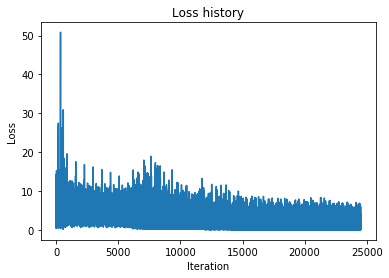

Test
=-=-=
Test acc: 0.55


Loading train trees..
Loading dev trees..
Loading test trees..
pos_trees 1852 1510
5058.0 total words with 1568 uniques

model name: rnn_embed=35_l2=0.160000_lr=0.010000.weights
l2 0.16
epoch 00
699 / 700 :    loss = 5.320666313171387
lr:  0.01

Training acc (only root node): 0.5228571428571429
Valiation acc (only root node): 0.5
[[ 168.  182.]
 [ 152.  198.]]
[[ 22.  28.]
 [ 22.  28.]]

copyfile: 1494028275.1093268   0
epoch 01
699 / 700 :    loss = 4.64138126373291
lr:  0.01

Training acc (only root node): 0.5257142857142857
Valiation acc (only root node): 0.48
[[ 165.  185.]
 [ 147.  203.]]
[[ 21.  29.]
 [ 23.  27.]]

copyfile: 1494028275.1093268   1
epoch 02
699 / 700 :    loss = 4.511968612670898
lr:  0.01

Training acc (only root node): 0.5385714285714286
Valiation acc (only root node): 0.53
[[  87.  263.]
 [  60.  290.]]
[[ 12.  38.]
 [  9.  41.]]

copyfile: 1494028275.1093268   2
epoch 03
699 / 700 :    loss = 4.449123859405518
lr:  0.01

Training ac

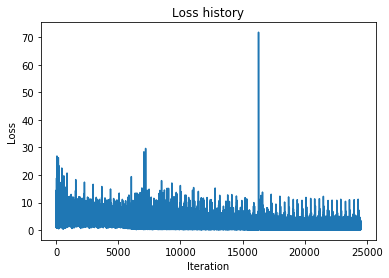

Test
=-=-=
Test acc: 0.545


Loading train trees..
Loading dev trees..
Loading test trees..
pos_trees 1852 1510
5058.0 total words with 1568 uniques

model name: rnn_embed=35_l2=0.300000_lr=0.010000.weights
l2 0.3
epoch 00
699 / 700 :    loss = 5.330991744995117
lr:  0.01

Training acc (only root node): 0.5171428571428571
Valiation acc (only root node): 0.56
[[ 163.  187.]
 [ 151.  199.]]
[[ 29.  21.]
 [ 23.  27.]]

copyfile: 1494065430.700282   0
epoch 01
699 / 700 :    loss = 4.6867899894714355
lr:  0.01

Training acc (only root node): 0.5
Valiation acc (only root node): 0.5
[[   0.  350.]
 [   0.  350.]]
[[  0.  50.]
 [  0.  50.]]
epoch 02
699 / 700 :    loss = 4.543208599090576
lr:  0.01

Training acc (only root node): 0.5
Valiation acc (only root node): 0.5
[[   0.  350.]
 [   0.  350.]]
[[  0.  50.]
 [  0.  50.]]

copyfile: 1494065430.700282   2
epoch 03
699 / 700 :    loss = 4.480805397033691
lr:  0.01

Training acc (only root node): 0.5
Valiation acc (only root node): 0.5
[[   

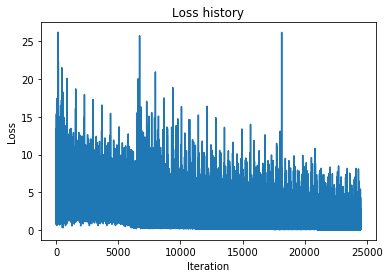

Test
=-=-=
Test acc: 0.5




In [4]:
RNN_Model.test2()

Loading train trees..
Loading dev trees..
Loading test trees..
pos_trees 1852 1510
5058.0 total words with 1568 uniques
l2 0.04
epoch 00
699 / 700 :    loss = 5.26880407333374
lr:  0.01

Training acc (only root node): 0.5285714285714286
Valiation acc (only root node): 0.61
[[ 266.   84.]
 [ 246.  104.]]
[[ 43.   7.]
 [ 32.  18.]]

copyfile: 1494253608.421785   0
epoch 01
699 / 700 :    loss = 4.550024032592773
lr:  0.01

Training acc (only root node): 0.5
Valiation acc (only root node): 0.5
[[   0.  350.]
 [   0.  350.]]
[[  0.  50.]
 [  0.  50.]]

copyfile: 1494253608.421785   1
epoch 02
699 / 700 :    loss = 4.466930866241455
lr:  0.01

Training acc (only root node): 0.5
Valiation acc (only root node): 0.5
[[   0.  350.]
 [   0.  350.]]
[[  0.  50.]
 [  0.  50.]]

copyfile: 1494253608.421785   2
epoch 03
699 / 700 :    loss = 4.414363384246826
lr:  0.01

Training acc (only root node): 0.5
Valiation acc (only root node): 0.5
[[   0.  350.]
 [   0.  350.]]
[[  0.  50.]
 [  0.  50.]]

c

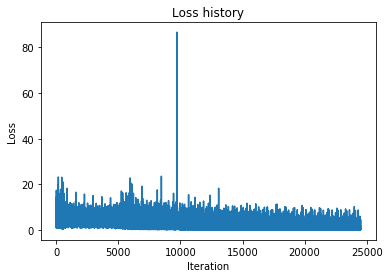

Test
=-=-=
Test acc: 0.715


In [6]:
RNN_Model.test_RNN()


# Check best and latest accuracies with test datas


In [4]:
config = Config()
model = RNN_Model(config)
#weights_path='./weights.bkp/%s'%model.config.model_name

Loading train trees..
Loading dev trees..
Loading test trees..
pos_trees 1852 1510
5058.0 total words with 1568 uniques


In [7]:
predictions, _ = model.predict(model.test_data, './weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.22')
labels = [t.root.label for t in model.test_data]
test_acc = np.equal(predictions, labels).mean()
print('Last epochs Test acc: {}'.format(test_acc))

predictions, _ = model.predict(model.test_data, './weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights')
labels = [t.root.label for t in model.test_data]
test_acc = np.equal(predictions, labels).mean()
print('Best epoch Test acc: {}'.format(test_acc))

Last epochs Test acc: 0.72
Best epoch Test acc: 0.73


In [9]:
#model_name = 'rnn_embed=%d_l2=%f_lr=%f.weights'%(embed_size, l2, lr)
for i in range(30):
    #print('./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.%d'%i)
    #print('Last epochs ', i ,' Test acc: {}'.format(0))
    predictions, _ = model.predict(model.test_data, './weights/l2/rnn_embed=35_l2=0.040000_lr=0.010000.weights.%d'%i)
    labels = [t.root.label for t in model.test_data]
    test_acc = np.equal(predictions, labels).mean()
    print('Last epochs ', i ,' Test acc: {}'.format(test_acc))

./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.0
Last epochs  0  Test acc: 0
Last epochs  0  Test acc: 0.5
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.1
Last epochs  1  Test acc: 0
Last epochs  1  Test acc: 0.53
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.2
Last epochs  2  Test acc: 0
Last epochs  2  Test acc: 0.535
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.3
Last epochs  3  Test acc: 0
Last epochs  3  Test acc: 0.545
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.4
Last epochs  4  Test acc: 0
Last epochs  4  Test acc: 0.55
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.5
Last epochs  5  Test acc: 0
Last epochs  5  Test acc: 0.575
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.6
Last epochs  6  Test acc: 0
Last epochs  6  Test acc: 0.585
./weights/l2=0.001/rnn_embed=35_l2=0.010000_lr=0.010000.weights.7
Last epochs  7  Test acc: 0
Last epochs  7  Test acc: 0.

# Analysis  hyper parameters (embeding_size, regularization) to accuracy

In [12]:
from bokeh.plotting import figure, show
#from bokeh.models import LabelSet, ColumnDataSource, Arrow
from bokeh.io import output_notebook, push_notebook
from bokeh.layouts import layout
from bokeh.models import (
    ColumnDataSource, HoverTool, SingleIntervalTicker, Slider, Button, Label,
    CategoricalColorMapper, LabelSet
)
output_notebook()

Loading BokehJS ...

*1493385677.txt embedding_size=35 40 epoch runs

*1493645061.txt embedding_size=70 40 epoch runs

In [6]:
train_acc_35=np.loadtxt('stat/bkp/train_acc_history.1493385677.txt')
val_acc_35=np.loadtxt('stat/bkp/val_acc_history.1493385677.txt')
train_acc_70=np.loadtxt('stat/bkp/train_acc_history.1493645061.txt')
val_acc_70=np.loadtxt('stat/bkp/val_acc_history.1493645061.txt')
x_35=[i*700 for i in range(len(train_acc_35))]
x_35_e=[i for i in range(len(train_acc_35))]

In [31]:
loss=np.loadtxt('./stat/loss_history.1493758844.rnn_embed=35_l2=0.040000_lr=0.010000.txt')
test_acc=np.loadtxt('./stat/train_acc_history.1493758844.rnn_embed=35_l2=0.040000_lr=0.010000.txt')
val_acc=np.loadtxt('./stat/val_acc_history.1493758844.rnn_embed=35_l2=0.040000_lr=0.010000.txt')
loss2=np.loadtxt('./stat/loss_history.1493997477.rnn_embed=35_l2=0.040000_lr=0.010000.txt')
test_acc2=np.loadtxt('./stat/train_acc_history.1493997477.rnn_embed=35_l2=0.040000_lr=0.010000.txt')
val_acc2=np.loadtxt('./stat/val_acc_history.1493997477.rnn_embed=35_l2=0.040000_lr=0.010000.txt')
x=[i*700 for i in range(len(loss))]
x2=[i for i in range(len(loss))]
x3=np.divide(x2,700)

In [34]:
print(np.min(loss2),np.argmin(loss2))

0.08123 22198


In [35]:
f_loss=figure(plot_width=800, plot_height=400)
f_loss.line(x3,loss)
f_loss2=figure(plot_width=800, plot_height=400)
f_loss2.line(x3,loss2)
f_acc=figure(plot_width=800, plot_height=400)
f_acc.line(x2,test_acc)
#f_val_acc=figure(plot_width=800, plot_height=400)
f_acc.line(x2,val_acc)
f_acc.line(x2,test_acc2, color='red')
f_acc.line(x2,val_acc2, color='red')
layout1=layout([[f_loss],[f_loss2],[f_acc]])
#show(f_loss)

C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: Co

In [36]:
show(layout1)

#### increasing embeding size does not offer better validation accuracy

In [7]:
f = figure(plot_width=800, plot_height=800)
f.line(x_35_e,train_acc_35)
f.line(x_35_e,val_acc_35,color='red')
f.line(x_35_e,train_acc_70,color='black')
f.line(x_35_e,val_acc_70,color='navy')
show(f)


# Examine ebedding using PCA


load saved embedding weights

In [11]:
#Restores saved training and get variable 'Composition/embedding'
with tf.Graph().as_default(), tf.Session() as sess:
    #save = tf.train.Saver()
    #save = tf.train.import_meta_graph('./weights/rnn_embed=35_l2=0.020000_lr=0.010000.weights.meta')
    #save.restore(sess, './weights/rnn_embed=35_l2=0.020000_lr=0.010000.weights')

    save = tf.train.import_meta_graph('./weights/rnn_embed=35_l2=0.040000_lr=0.010000.weights.0.meta')
    save.restore(sess, './weights/rnn_embed=35_l2=0.040000_lr=0.010000.weights.0')
    
    for var in tf.global_variables():
        print(var.op.name)
        if var.op.name == 'Embedding/embedding':
            #with tf.variable_scope('Embedding', reuse=False):
            #    emd = tf.get_variable("embedding")
            x_temp=sess.run(var)    

Embedding/embedding
Composition/W1
Composition/b1
Projection/U
Projection/bs


In [12]:
with tf.Graph().as_default(), tf.Session() as sess:
    #save = tf.train.Saver()
    #save = tf.train.import_meta_graph('./weights/rnn_embed=35_l2=0.020000_lr=0.010000.weights.meta')
    #save.restore(sess, './weights/rnn_embed=35_l2=0.020000_lr=0.010000.weights')

    save = tf.train.import_meta_graph('./weights/rnn_embed=35_l2=0.040000_lr=0.010000.weights.21.meta')
    save.restore(sess, './weights/rnn_embed=35_l2=0.040000_lr=0.010000.weights.21')
    
    for var in tf.global_variables():
        print(var.op.name)
        if var.op.name == 'Embedding/embedding':
            #with tf.variable_scope('Embedding', reuse=False):
            #    emd = tf.get_variable("embedding")
            x_acc=sess.run(var)   

Embedding/embedding
Composition/W1
Composition/b1
Projection/U
Projection/bs


get 100 random words from Vocab

In [11]:
rand_words_idx=np.random.random_integers(1,1571,size=[20])

C:\Users\h_agu\Desktop\machine_learning\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 1571 + 1) instead
  if __name__ == '__main__':


In [8]:
#model.vocab.word_freq
words=['good','bad','well','sucks','sucked','fascinating'
       ,'humorless','delight','hated','awful','witty'
       ,'fun','best','of','on','comedy','documentary','drama']
rand_words_idx=[model.vocab.encode(wd) for i,wd in enumerate(words)]

In [9]:
X1=[x_temp[rand_words_idx[i]] for i in range(len(rand_words_idx))]
X2=[x_acc[rand_words_idx[i]] for i in range(len(rand_words_idx))]
Y=[model.vocab.index_to_word[rand_words_idx[i]] for i in range(len(rand_words_idx))]

NameError: name 'x_temp' is not defined

In [10]:
from sklearn import decomposition
from sklearn import datasets

pca = decomposition.PCA(n_components=2)
pca.fit(x_temp)
Xpca = pca.transform(X1)

pca2 = decomposition.PCA(n_components=2)
pca2.fit(x_acc)
X2pca = pca2.transform(X2)

NameError: name 'x_temp' is not defined

In [16]:
plot = figure(plot_width=800, plot_height=800)
plot.x(Xpca[:,0],Xpca[:,1])
plot.asterisk(X2pca[:,0],X2pca[:,1])
plot.segment(Xpca[:,0], Xpca[:,1], X2pca[:,0],X2pca[:,1],line_alpha=1/3)

source=ColumnDataSource(data={'x1':Xpca[:,0], 'x2':Xpca[:,1], 'y': Y})
source2=ColumnDataSource(data={'x1':X2pca[:,0], 'x2':X2pca[:,1], 'y': Y})

labels = LabelSet(x='x1', y='x2', text='y', level='glyph',
                  x_offset=0, y_offset=1
                  , render_mode='canvas'
                  , source=source
                  , text_font_size="9pt"
                 )

labels2 = LabelSet(x='x1', y='x2', text='y', level='glyph',
                  x_offset=0, y_offset=1
                  , render_mode='canvas'
                  , source=source2
                  , text_color = 'Red'
                  , text_font_size="9pt"
                 )

plot.add_layout(labels)
plot.add_layout(labels2)

handle=show(plot,notebook_handle=True)
push_notebook(handle=handle)

In [9]:
from sklearn import decomposition

def get_pca(embed,idx,n_component=2):
    x=[embed[idx[i]] for i in range(len(idx))]
    pca = decomposition.PCA(n_component)
    pca.fit(embed)
    return pca.transform(x)

In [10]:
data=np.loadtxt('embed/embed_1493758844')

In [11]:
import pandas as pd
pca=[]
steps=[data[:,0]][0]
for i, slice in enumerate(data[:,2:]):
    a=get_pca(np.reshape(slice,[-1,35]),rand_words_idx)
    for j in range(len(a)):
        pca.append([data[i,0], data[i,1], a[j,0], a[j,1], rand_words_idx[j]])
pca=np.array(pca)
_pca=dict({'step':pca[:,0], 'epoch': pca[:,1], 'x1' : pca[:,2], 'x2' : pca[:,3], 'widx' : pca[:,4]})
pca_data=pd.DataFrame(_pca)

#pca_data['label']=""

#[pca_data.loc[pca_data.widx == idx].update = model.vocab.decode(idx) for i, idx in enumerate(rand_words_idx)]
for i, idx in enumerate(rand_words_idx):
    pca_data.loc[pca_data.widx == idx, 'label'] = model.vocab.decode(idx)

def pca_step(i):
    #print (len(pca_data))
    return pca_data[pca_data['step']== i]

In [14]:
from ipywidgets import interact

source = ColumnDataSource(data=pca_step(1))
f1 = figure(plot_width=800, plot_height=800, x_range=(-0.1,0.1), y_range=(-0.1,0.1))
#x1=f1.x(x='x1',y='x2',source=source)
labelz = LabelSet(x='x1', y='x2', text='label', level='glyph',
                  x_offset=0, y_offset=1
                  , render_mode='canvas'
                  , source=source
                  , text_font_size="9pt"
                 )
f1.add_layout(labelz)

def animate_update():
    step = slider.value + 1
    if step > steps[-1]:
        step = steps[0]
    slider.value = step

def update(steps):
    print("steps",steps)
    #step = slider.value
    #label.text = str(step)
    data=pca_step(int(steps))
    #new_source = ColumnDataSource(data=pca_step(int(steps)))
    #x1.data_source.data['x'] = data['x1']
    #x1.data_source.data['y'] = data['x2']
    labelz.source = ColumnDataSource(data=data)
    source = ColumnDataSource(data)
    #source.data = dict({'x':data['x1'], 'y':data['x1'], 'label': data['label']})
    push_notebook(handle=h)

#slider = Slider(start=steps[0], end=steps[-1], value=steps[0], step=1, title="Step")
#slider.on_change('value', slider_update)

#layout = layout([
#    [f1],
#], sizing_mode='scale_width')

#def animate():
#    if button.label == '► Play':
#        button.label = '❚❚ Pause'
#        curdoc().add_periodic_callback(animate_update, 200)
#    else:
#        button.label = '► Play'
#        curdoc().remove_periodic_callback(animate_update)

h=show(f1,notebook_handle=True)

In [15]:
interact(update,steps=[int(steps[0]),int(steps[-1])])

steps 210


In [18]:
def slider_update(attr, old, new):
    print("old",old)
    print("new",new)
    
slider = Slider(start=steps[0], end=steps[-1], value=steps[0], step=1, title="Step")
slider.on_change('value', slider_update)
show(slider)

In [90]:
class LineTracer():
    def render(self,x,y, label=None, trace_points=3,refresh=False):
        if len(x) != len(y):
            print("x length != y")
            return None
        if refresh:
            __init__()
            
        X=self.X
        Y=self.Y
        X.append(x)
        Y.append(y)
        fig=self.fig
        if len(X) == 1:
            #print("first coor")
            print(len(x),len(y),len(label))
            ###source=ColumnDataSource({'x':x , 'y':y, 'label':label})
            #self.fig.x(x='x',y='y', source=self.sources[0])
            #fig.x(x,y,source=source)
            #lbl = LabelSet(x='x', y='y', text=label, level='glyph',
            #      x_offset=0, y_offset=1
            #      , render_mode='canvas'
            #      , source=source
            #      , text_font_size="9pt"
            #     )
            #fig.add_layout(lbl)
            
        else :
            #print('X',len(X),'Y',len(Y))
            for i in range(trace_points):
                alpha=1/(i+1)
                #print(alpha)
                if i == (trace_points-1):
                    alpha=0
                idx=(len(X)-1)-i
                if idx < 0:
                    break
                #source=ColumnDataSource
                print(idx,X[idx-1],X[idx])
                seg=fig.segment(X[idx-1],Y[idx-1],X[idx],Y[idx], line_alpha=alpha)
                fig.add_layout(seg)
            #self.handle=show(fig,notebook_handle=True)
        #self.handle=show(fig,notebook_handle=True)
        #push_notebook(handle=self.handle)
        return fig

    #def __render__(self,x,y, label=None, trace_points=3,refresh=False):
        
         
    def __init__(self):
        self.X=[]
        self.Y=[]
        self.count=0
        self.fig = figure(plot_width=800, plot_height=800, x_range=(-0.1,0.1), y_range=(-0.1,0.1))
        #self.sources=dict()
        self.handle=None

# Appendix(notes and stuff)

In [7]:
embed_size=10
train,dev,test=tr.simplified_data(100, 2, 2)
vocab = Vocab()
train_sents = [t.get_words() for t in train]
vocab.construct(list(itertools.chain.from_iterable(train_sents)))
word_vec=np.random.uniform(0.0,1.0,size=[len(vocab.word_freq),embed_size])
W1=np.random.uniform(size=[2*embed_size,embed_size],low=-1.0,high=1.0)
b1=np.zeros([1,embed_size])

Loading train trees..
Loading dev trees..
Loading test trees..
pos_trees 1852 1510
349.0 total words with 174 uniques


In [303]:
print(W1.shape)
def inspect_node(node,i=0,loc="root"):
        node_tensors = dict()
        curr_node_tensor = None
        if i == 0:
            print ("root")
        i=i+1
        if node.isLeaf:
            curr_node_tensor=word_vec[vocab.word_to_index[node.word]]
        else:
            node_tensors.update(inspect_node(node.left,i,"left"))
            node_tensors.update(inspect_node(node.right,i,"right"))
            h1=np.maximum(np.dot(np.concatenate((node_tensors[node.right],node_tensors[node.left]),axis=0),W1)+b1,0)
            curr_node_tensor=h1[0]
        node_tensors[node] = curr_node_tensor
        return node_tensors

(20, 10)


In [46]:
out=[]
for i in range(len(w)):
    x=np.array(w[i])
    x=x.ravel()
    out.append(x)
    if i > 0:
        print(np.sum(out[i]-out[i-1]))

-43.4855
27.717
4.75043
-12.3224
-2.26039
14.3535
-18.0842
-2.17549
23.8564


In [1]:
from tensorflow.python.summary import event_accumulator
from tensorflow.tensorboard.scripts import serialize_tensorboard 
from tensorflow.tensorboard.backend import server

In [2]:
size_guide={
        event_accumulator.COMPRESSED_HISTOGRAMS: 500,
        event_accumulator.IMAGES: 4,
        event_accumulator.AUDIO: 4,
        event_accumulator.SCALARS: 0,
        event_accumulator.HISTOGRAMS: 1,
    }

In [3]:
ea = event_accumulator.EventAccumulator('tensorboard/log/normal/epoch_0/events.out.tfevents.1493130393.GANDALF',size_guidance=size_guide)

In [18]:
ea.Reload()

In [24]:
ea.Tags()

{'audio': [],
 'compressedHistograms': ['inference/Composition_19/h_weight_W1',
  'inference/Composition_4/h_weight_W1',
  'inference/Composition_11/bias_b1',
  'inference/Composition_19/bias_b1',
  'inference/Composition_11/h_weight_W1',
  'inference/Embedding_2/embedding',
  'inference/Composition_18/bias_b1',
  'inference/Composition_17/bias_b1',
  'inference/Composition_5/h_weight_W1',
  'inference/Composition_16/h_weight_W1',
  'inference/Composition_14/bias_b1',
  'inference/Composition_16/bias_b1',
  'inference/Composition_10/h_weight_W1',
  'inference/Projection/p_weight_U',
  'inference/Embedding_5/embedding',
  'inference/Projection/bias_bs',
  'inference/Embedding_6/embedding',
  'inference/Composition_15/h_weight_W1',
  'inference/Composition_15/bias_b1',
  'inference/Composition_6/h_weight_W1',
  'inference/Composition_8/bias_b1',
  'inference/Embedding_13/embedding',
  'inference/Embedding_9/embedding',
  'inference/Embedding_15/embedding',
  'inference/Embedding_1/embedd

In [23]:
ea.Scalars('loss_1')

[ScalarEvent(wall_time=1493130393.7003062, step=0, value=7.609586715698242),
 ScalarEvent(wall_time=1493130511.4744577, step=100, value=4.9630231857299805),
 ScalarEvent(wall_time=1493130632.7865264, step=200, value=12.159689903259277),
 ScalarEvent(wall_time=1493130749.1567585, step=300, value=0.33783480525016785),
 ScalarEvent(wall_time=1493130867.4703195, step=400, value=2.2717533111572266),
 ScalarEvent(wall_time=1493130987.4041247, step=500, value=1.3518928289413452),
 ScalarEvent(wall_time=1493131103.0428867, step=600, value=2.4804422855377197)]

In [25]:
ea.CompressedHistograms('inference/Embedding_2/embedding')

[CompressedHistogramEvent(wall_time=1493130393.7003062, step=0, compressed_histogram_values=[CompressedHistogramValue(basis_point=0, value=-0.043739061802625656), CompressedHistogramValue(basis_point=668, value=-0.037814731571536545), CompressedHistogramValue(basis_point=1587, value=-0.029660519923265061), CompressedHistogramValue(basis_point=3085, value=-0.016582775584833807), CompressedHistogramValue(basis_point=5000, value=0.0002491357326870716), CompressedHistogramValue(basis_point=6915, value=0.016992976644274006), CompressedHistogramValue(basis_point=8413, value=0.029936749102752867), CompressedHistogramValue(basis_point=9332, value=0.037969025070335352), CompressedHistogramValue(basis_point=10000, value=0.04374067112803459)]),
 CompressedHistogramEvent(wall_time=1493130511.4744577, step=100, compressed_histogram_values=[CompressedHistogramValue(basis_point=0, value=-0.043740782886743546), CompressedHistogramValue(basis_point=668, value=-0.037982794233539861), CompressedHistogram

In [32]:
ea.Histograms('inference/Embedding_2/embedding')

[HistogramEvent(wall_time=1493131103.0428867, step=600, histogram_value=HistogramValue(min=-0.043740302324295044, max=0.04374018684029579, num=54880.0, sum=-6.156110845506191, sum_squares=35.1140864450777, bucket_limit=[-0.04778733052417259, -0.043443027749247805, -0.03949366159022527, -0.035903328718386605, -0.03263938974398782, -0.02967217249453438, -0.026974702267758523, -0.0245224566070532, -0.022293142370048362, -0.02026649306368033, -0.018424084603345752, -0.01674916782122341, -0.01522651620111219, -0.013842287455556535, -0.012583897686869577, -0.01143990698806325, -0.010399915443693864, -0.00945446858517624, -0.008594971441069308, -0.007813610400972098, -0.007103282182701907, -0.006457529257001733, -0.005870481142728848, -0.005336801038844407, -0.00485163730804037, -0.00441057937094579, -0.004009617609950718, -0.0036451069181370156, -0.003313733561942741, -0.0030124850563115826, -0.002738622778465075, -0.0024896570713318863, -0.0022633246103017147, -0.0020575678275470133, -0.001

In [33]:
bucket_limit=[-0.04778733052417259, -0.043443027749247805, -0.03949366159022527, -0.035903328718386605, -0.03263938974398782, -0.02967217249453438, -0.026974702267758523, -0.0245224566070532, -0.022293142370048362, -0.02026649306368033, -0.018424084603345752, -0.01674916782122341, -0.01522651620111219, -0.013842287455556535, -0.012583897686869577, -0.01143990698806325, -0.010399915443693864, -0.00945446858517624, -0.008594971441069308, -0.007813610400972098, -0.007103282182701907, -0.006457529257001733, -0.005870481142728848, -0.005336801038844407, -0.00485163730804037, -0.00441057937094579, -0.004009617609950718, -0.0036451069181370156, -0.003313733561942741, -0.0030124850563115826, -0.002738622778465075, -0.0024896570713318863, -0.0022633246103017147, -0.0020575678275470133, -0.001870516206860921, -0.0017004692789644735, -0.0015458811626949758, -0.001405346511540887, -0.0012775877377644426, -0.001161443397967675, -0.001055857634516068, -0.0009598705768327891, -0.0008726096153025355, -0.0007932814684568504, -0.0007211649713244094, -0.0006556045193858267, -0.0005960041085325697, -0.0005418219168477906, -0.0004925653789525368, -0.0004477867081386698, -0.0004070788255806089, -0.0003700716596187353, -0.00033642878147157755, -0.0003058443467923432, -0.0002780403152657665, -0.00025276392296887866, -0.0002297853845171624, -0.00020889580410651126, -0.00018990527646046477, -0.00017264116041860433, -0.00015694650947145847, -0.00014267864497405315, -0.00012970785906732103, -0.00011791623551574639, -0.00010719657774158762, -9.745143431053419e-05, -8.859221300957652e-05, -8.053837546325138e-05, -7.321670496659217e-05, -6.656064087872014e-05, -6.050967352610922e-05, -5.500879411464474e-05, -5.000799464967703e-05, -4.546181331788821e-05, -4.132892119808019e-05, -3.757174654370926e-05, -3.415613322155387e-05, -3.1051030201412604e-05, -2.822820927401146e-05, -2.5662008430919505e-05, -2.3329098573563184e-05, -2.1208271430511985e-05, -1.9280246755010893e-05, -1.7527497050009902e-05, -1.593408822728173e-05, -1.44855347520743e-05, -1.316866795643118e-05, -1.1971516324028345e-05, -1.0883196658207586e-05, -9.893815143825077e-06, -8.994377403477343e-06, -7.4333697549399525e-06, -6.757608868127229e-06, -5.584800717460519e-06, -5.077091561327744e-06, -4.615537783025222e-06, -4.1959434391138375e-06, 3.200568495929872e-07, 3.5206253455228594e-07, 4.1959434391138375e-06, 4.615537783025222e-06, 5.077091561327744e-06, 6.757608868127229e-06, 7.4333697549399525e-06, 9.893815143825077e-06, 1.0883196658207586e-05, 1.1971516324028345e-05, 1.316866795643118e-05, 1.44855347520743e-05, 1.593408822728173e-05, 1.7527497050009902e-05, 1.9280246755010893e-05, 2.1208271430511985e-05, 2.3329098573563184e-05, 2.5662008430919505e-05, 2.822820927401146e-05, 3.1051030201412604e-05, 3.415613322155387e-05, 3.757174654370926e-05, 4.132892119808019e-05, 4.546181331788821e-05, 5.000799464967703e-05, 5.500879411464474e-05, 6.050967352610922e-05, 6.656064087872014e-05, 7.321670496659217e-05, 8.053837546325138e-05, 8.859221300957652e-05, 9.745143431053419e-05, 0.00010719657774158762, 0.00011791623551574639, 0.00012970785906732103, 0.00014267864497405315, 0.00015694650947145847, 0.00017264116041860433, 0.00018990527646046477, 0.00020889580410651126, 0.0002297853845171624, 0.00025276392296887866, 0.0002780403152657665, 0.0003058443467923432, 0.00033642878147157755, 0.0003700716596187353, 0.0004070788255806089, 0.0004477867081386698, 0.0004925653789525368, 0.0005418219168477906, 0.0005960041085325697, 0.0006556045193858267, 0.0007211649713244094, 0.0007932814684568504, 0.0008726096153025355, 0.0009598705768327891, 0.001055857634516068, 0.001161443397967675, 0.0012775877377644426, 0.001405346511540887, 0.0015458811626949758, 0.0017004692789644735, 0.001870516206860921, 0.0020575678275470133, 0.0022633246103017147, 0.0024896570713318863, 0.002738622778465075, 0.0030124850563115826, 0.003313733561942741, 0.0036451069181370156, 0.004009617609950718, 0.00441057937094579, 0.00485163730804037, 0.005336801038844407, 0.005870481142728848, 0.006457529257001733, 0.007103282182701907, 0.007813610400972098, 0.008594971441069308, 0.00945446858517624, 0.010399915443693864, 0.01143990698806325, 0.012583897686869577, 0.013842287455556535, 0.01522651620111219, 0.01674916782122341, 0.018424084603345752, 0.02026649306368033, 0.022293142370048362, 0.0245224566070532, 0.026974702267758523, 0.02967217249453438, 0.03263938974398782, 0.035903328718386605, 0.03949366159022527, 0.043443027749247805, 0.04778733052417259, 1.7976931348623157e+308]

In [36]:
len(bucket_limit)

195

In [65]:
from os import walk
mypath='tensorboard/log/normal'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    for i, dir in enumerate(dirnames):
        path=None
        path=dirpath+'/'+dir
        print(path)
        for (_, dirnames, filenames) in walk(path):
            print('-----',filenames)
            break
    break

tensorboard/log/normal/epoch_0
----- ['events.out.tfevents.1493130393.GANDALF']
tensorboard/log/normal/epoch_1
----- ['events.out.tfevents.1493131475.GANDALF']
tensorboard/log/normal/epoch_10
----- ['events.out.tfevents.1493140797.GANDALF']
tensorboard/log/normal/epoch_11
----- ['events.out.tfevents.1493141848.GANDALF']
tensorboard/log/normal/epoch_12
----- ['events.out.tfevents.1493142964.GANDALF']
tensorboard/log/normal/epoch_13
----- ['events.out.tfevents.1493144020.GANDALF']
tensorboard/log/normal/epoch_14
----- ['events.out.tfevents.1493145061.GANDALF']
tensorboard/log/normal/epoch_15
----- ['events.out.tfevents.1493146100.GANDALF']
tensorboard/log/normal/epoch_16
----- ['events.out.tfevents.1493147139.GANDALF']
tensorboard/log/normal/epoch_17
----- ['events.out.tfevents.1493148176.GANDALF']
tensorboard/log/normal/epoch_18
----- ['events.out.tfevents.1493149214.GANDALF']
tensorboard/log/normal/epoch_19
----- ['events.out.tfevents.1493150251.GANDALF']
tensorboard/log/normal/epoch_2

In [66]:
import glob

In [69]:
glob.glob("tensorboard/log/*.GANDALF")

[]

In [12]:
a=np.ones([10,9])

In [26]:
a[3][:]=0

In [11]:
a

NameError: name 'a' is not defined

In [28]:
np.savetxt("'array_test.%02d.%f.txt'%x,%start_time",a,fmt='%f')

In [31]:
'.%d.txt'%start_time

'.1493211069.txt'

In [33]:
'array_test.%02d'%x+'.%s.txt'%start_time

'array_test.01.1493211069.4690259.txt'

In [14]:
x=1
print('%02d'%x)

01


In [76]:
z='%02d'%x
z

'01'

In [61]:
b=[]
a=[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]]

In [62]:
a

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [66]:
b.append((np.array(a).T).ravel())

In [67]:
len(b)

2

In [68]:
b

[array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  

In [70]:
x=np.loadtxt('array_test.txt')

In [71]:
x

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [73]:
x[:,0]

array([ 1.,  1.])

In [8]:
start_time = time.time()

In [9]:
start_time

1493211069.4690259

In [27]:
a=dict()

In [31]:
a['1']='a'

In [32]:
a

{'1': 'a'}

In [35]:
ini=tf.random_normal([model.config.embed_size,len(model.vocab.word_freq)],stddev=0.02)
with tf.Session() as sess:
    x=sess.run([ini])


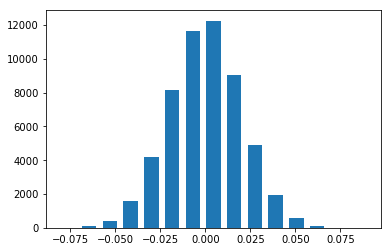

In [36]:
#x2=np.random.normal(scale=0.05,size=[model.config.embed_size,len(model.vocab.word_freq)])
hist, bins = np.histogram(x, bins=15)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [40]:
np.sum(x2)

1.3778963089319767